# EDA for Log Reports

In [1]:
from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read all csv files. Include the filepath
log_path = Path("../outputs/logs/")
df = pl.DataFrame([])

for file_path in log_path.glob("**/*.csv"):
    current_df = pl.read_csv(file_path)
    current_df = current_df.with_columns(filepath = pl.lit(str(file_path)))
    df = pl.concat([df, current_df])
    
print(df.shape)
df.head(5)

(53384, 4)


location,error_code,error_description,filepath
str,str,str,str
"""Line 4 Sent 1""","""L4 Morpho feat…","""Feature Polite…","""../outputs/log…"
"""Line 12 Sent 2…","""L4 Morpho feat…","""Feature NumTyp…","""../outputs/log…"
"""Line 13 Sent 2…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…"
"""Line 25 Sent 3…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…"
"""Line 25 Sent 3…","""L4 Morpho feat…","""Value Sing of …","""../outputs/log…"


## What are the most common errors?

The most common error is the "L4 Morpho feature-upos-not-permitted." This happens when a UPOS tag is not in the current tag set of a language. The solution here is to edit the tag set in UD and include those missing tags. 

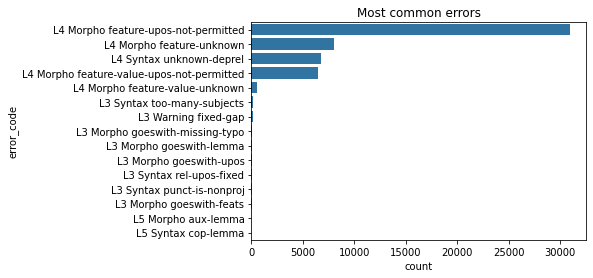

In [3]:
sns.barplot(
    df["error_code"].value_counts(sort=True).to_pandas(),
    x="count",
    y="error_code",
).set_title("Most common errors")
plt.savefig("figures/most_common_error.png", bbox_inches="tight", dpi=300)

Some errors, such as `L4 Morpho feature-upos-not-permitted` and `L4 Morpho feature-value-upos-not-permitted` and `L4 Morpho feature-value-unknown`, look quite the same. According to the UD documentation, [L4 means "language-specific labels"](https://universaldependencies.org/validation-rules.html): 

> Morphological features (FEATS) and relation types (DEPREL and DEPS) allow language-specific extensions. Therefore the lower levels checked only the general format of these columns but not the actual labels. Level 4 assumes that we know the language of the data we are validating and we can check a list of available labels in a separate file. The current practice is that maintainers of treebanks of a given language collectively maintain the lists of labels for that language. A feature-value pair is considered valid if it is documented in the guidelines (either globally or specifically for the language) and it is specifically permitted with the given UPOS tag in the given language. A relation subtype is considered valid if it is documented and permitted (turned on) in the given language.

We then want to know what are the common missing UPOS features from our annotations.

In [4]:
has_l4 = df["error_code"].str.contains("L4")
df.filter(has_l4).head(5)

location,error_code,error_description,filepath
str,str,str,str
"""Line 4 Sent 1""","""L4 Morpho feat…","""Feature Polite…","""../outputs/log…"
"""Line 12 Sent 2…","""L4 Morpho feat…","""Feature NumTyp…","""../outputs/log…"
"""Line 13 Sent 2…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…"
"""Line 25 Sent 3…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…"
"""Line 25 Sent 3…","""L4 Morpho feat…","""Value Sing of …","""../outputs/log…"


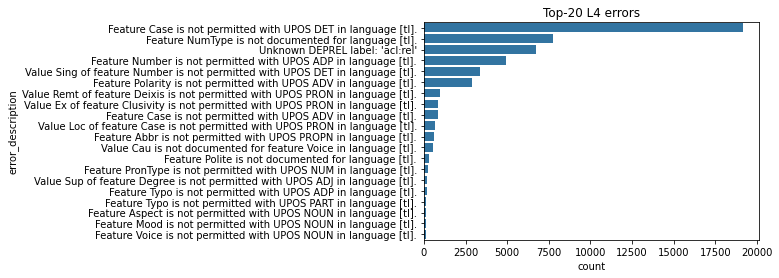

In [5]:
top_k = 20  # Let's get the top 10 for now
sns.barplot(
    df.filter(has_l4)["error_description"].value_counts(sort=True).head(top_k).to_pandas(),
    x="count",
    y="error_description",
).set_title(f"Top-{top_k} L4 errors")
plt.savefig(f"figures/top_{top_k}_l4_errors.png", bbox_inches="tight", dpi=300) 

## What are the missing features / values for each UPOS tag? How frequent are they?

Here, I want to arrange the L4 errors more neatly by the [UPOS tag](https://universaldependencies.org/u/pos/) they correspond to. This allows us to easily see per tag what we should add.

In [6]:
df_l4 = df.filter(has_l4)

In [7]:
import re
from typing import Dict, Optional


def extract_info(description) -> Dict[str, Optional[str]]:
    result = {"UPOS": None, "Feature": None, "Value": None}

    description = description.split(" ")
    start_marker = description[0]

    if start_marker == "Feature":
        result["Feature"] = description[1]
        try:
            result["UPOS"] = description[description.index("UPOS") + 1]
        except Exception:
            pass

    if start_marker == "Value":
        result["Value"] = description[1]
        result["Feature"] = description[description.index("feature") + 1]
        try:
            result["UPOS"] = description[description.index("UPOS") + 1]
        except Exception:
            pass

    return result


df_l4_upos = df_l4.with_columns(
    pl.col("error_description")
    .map_elements(lambda x: extract_info(x))
    .map_elements(lambda x: x["UPOS"], return_dtype=str)
    .alias("UPOS"),
    pl.col("error_description")
    .map_elements(lambda x: extract_info(x))
    .map_elements(lambda x: x["Feature"], return_dtype=str)
    .alias("Feature"),
    pl.col("error_description")
    .map_elements(lambda x: extract_info(x))
    .map_elements(lambda x: x["Value"], return_dtype=str)
    .alias("Value"),
)

df_l4_upos.head(10)

location,error_code,error_description,filepath,UPOS,Feature,Value
str,str,str,str,str,str,str
"""Line 4 Sent 1""","""L4 Morpho feat…","""Feature Polite…","""../outputs/log…",null,"""Polite""",null
"""Line 12 Sent 2…","""L4 Morpho feat…","""Feature NumTyp…","""../outputs/log…",null,"""NumType""",null
"""Line 13 Sent 2…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…","""DET""","""Case""",null
"""Line 25 Sent 3…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…","""DET""","""Case""",null
"""Line 25 Sent 3…","""L4 Morpho feat…","""Value Sing of …","""../outputs/log…","""DET""","""Number""","""Sing"""
"""Line 31 Sent 4…","""L4 Morpho feat…","""Feature Polari…","""../outputs/log…","""ADV""","""Polarity""",null
"""Line 40 Sent 5…","""L4 Morpho feat…","""Feature Polari…","""../outputs/log…","""ADV""","""Polarity""",null
"""Line 43 Sent 5…","""L4 Morpho feat…","""Feature Case i…","""../outputs/log…","""DET""","""Case""",null
"""Line 54 Sent 6…","""L4 Syntax unkn…","""Unknown DEPREL…","""../outputs/log…",null,null,null


Let's check for cases where we didn't catch anything. So far, most of them are unknown DEPREL tags. We can live with that, so let's remove them from our dataframe.

In [8]:
# Check for cases where you didn't catch anything
all_nulls = df_l4_upos.filter(
        df_l4_upos["UPOS"].is_null()
        & df_l4_upos["Feature"].is_null()
        & df_l4_upos["Value"].is_null()
    )
print(f"Missed: {len(all_nulls)}")

df_l4_upos = df_l4_upos.drop_nulls(subset=["UPOS"]).sort(by="UPOS")
df_l4_upos = df_l4_upos[["filepath", "location", "UPOS", "Feature", "Value", "error_code", "error_description"]]
df_l4_upos.head(10)

Missed: 6759


filepath,location,UPOS,Feature,Value,error_code,error_description
str,str,str,str,str,str,str
"""../outputs/log…","""Line 1626 Sent…","""ADJ""","""Degree""","""Abs""","""L4 Morpho feat…","""Value Abs of f…"
"""../outputs/log…","""Line 1428 Sent…","""ADJ""","""Degree""","""Sup""","""L4 Morpho feat…","""Value Sup of f…"
"""../outputs/log…","""Line 13 Sent 2…","""ADJ""","""Degree""","""Abs""","""L4 Morpho feat…","""Value Abs of f…"
"""../outputs/log…","""Line 286 Sent …","""ADJ""","""Degree""","""Sup""","""L4 Morpho feat…","""Value Sup of f…"
"""../outputs/log…","""Line 125 Sent …","""ADJ""","""Degree""","""Abs""","""L4 Morpho feat…","""Value Abs of f…"
"""../outputs/log…","""Line 362 Sent …","""ADJ""","""Degree""","""Abs""","""L4 Morpho feat…","""Value Abs of f…"
"""../outputs/log…","""Line 380 Sent …","""ADJ""","""Degree""","""Abs""","""L4 Morpho feat…","""Value Abs of f…"
"""../outputs/log…","""Line 513 Sent …","""ADJ""","""Degree""","""Sup""","""L4 Morpho feat…","""Value Sup of f…"
"""../outputs/log…","""Line 951 Sent …","""ADJ""","""Degree""","""Sup""","""L4 Morpho feat…","""Value Sup of f…"


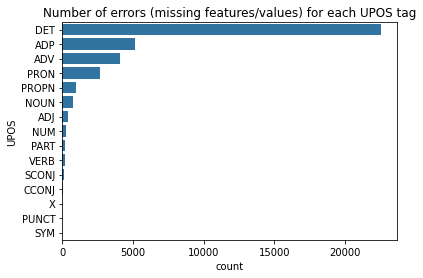

In [39]:
sns.barplot(
    df_l4_upos.group_by("UPOS").count().sort(by="count", descending=True).to_pandas(),
    x="count",
    y="UPOS",
).set_title("Number of errors (missing features/values) for each UPOS tag")
plt.savefig("figures/upos_tags_with_error_counts.png", bbox_inches="tight", dpi=300) 

In [22]:
def plot_stacked_barchart(ax, upos_tag: str, df: pl.DataFrame):
    df_tag = df.filter(df["UPOS"] == upos_tag).fill_null("Unspec.")
    counts = (
        df_tag[["UPOS", "Feature", "Value"]]
        .group_by(["Feature", "Value"])
        .count()
        .sort(by="count", descending=True)
    )
    plot = counts.to_pandas().pivot(
        index="Feature",
        columns="Value",
        values="count",
    ).fillna(0).plot(
        kind="barh",
        ax=ax,
        stacked=True,
        colormap="tab20",
        edgecolor="black",
        title=f"UPOS Tag: {upos_tag}",
        xlabel="Counts",
        ylabel="Features",
    )
    
    return plot

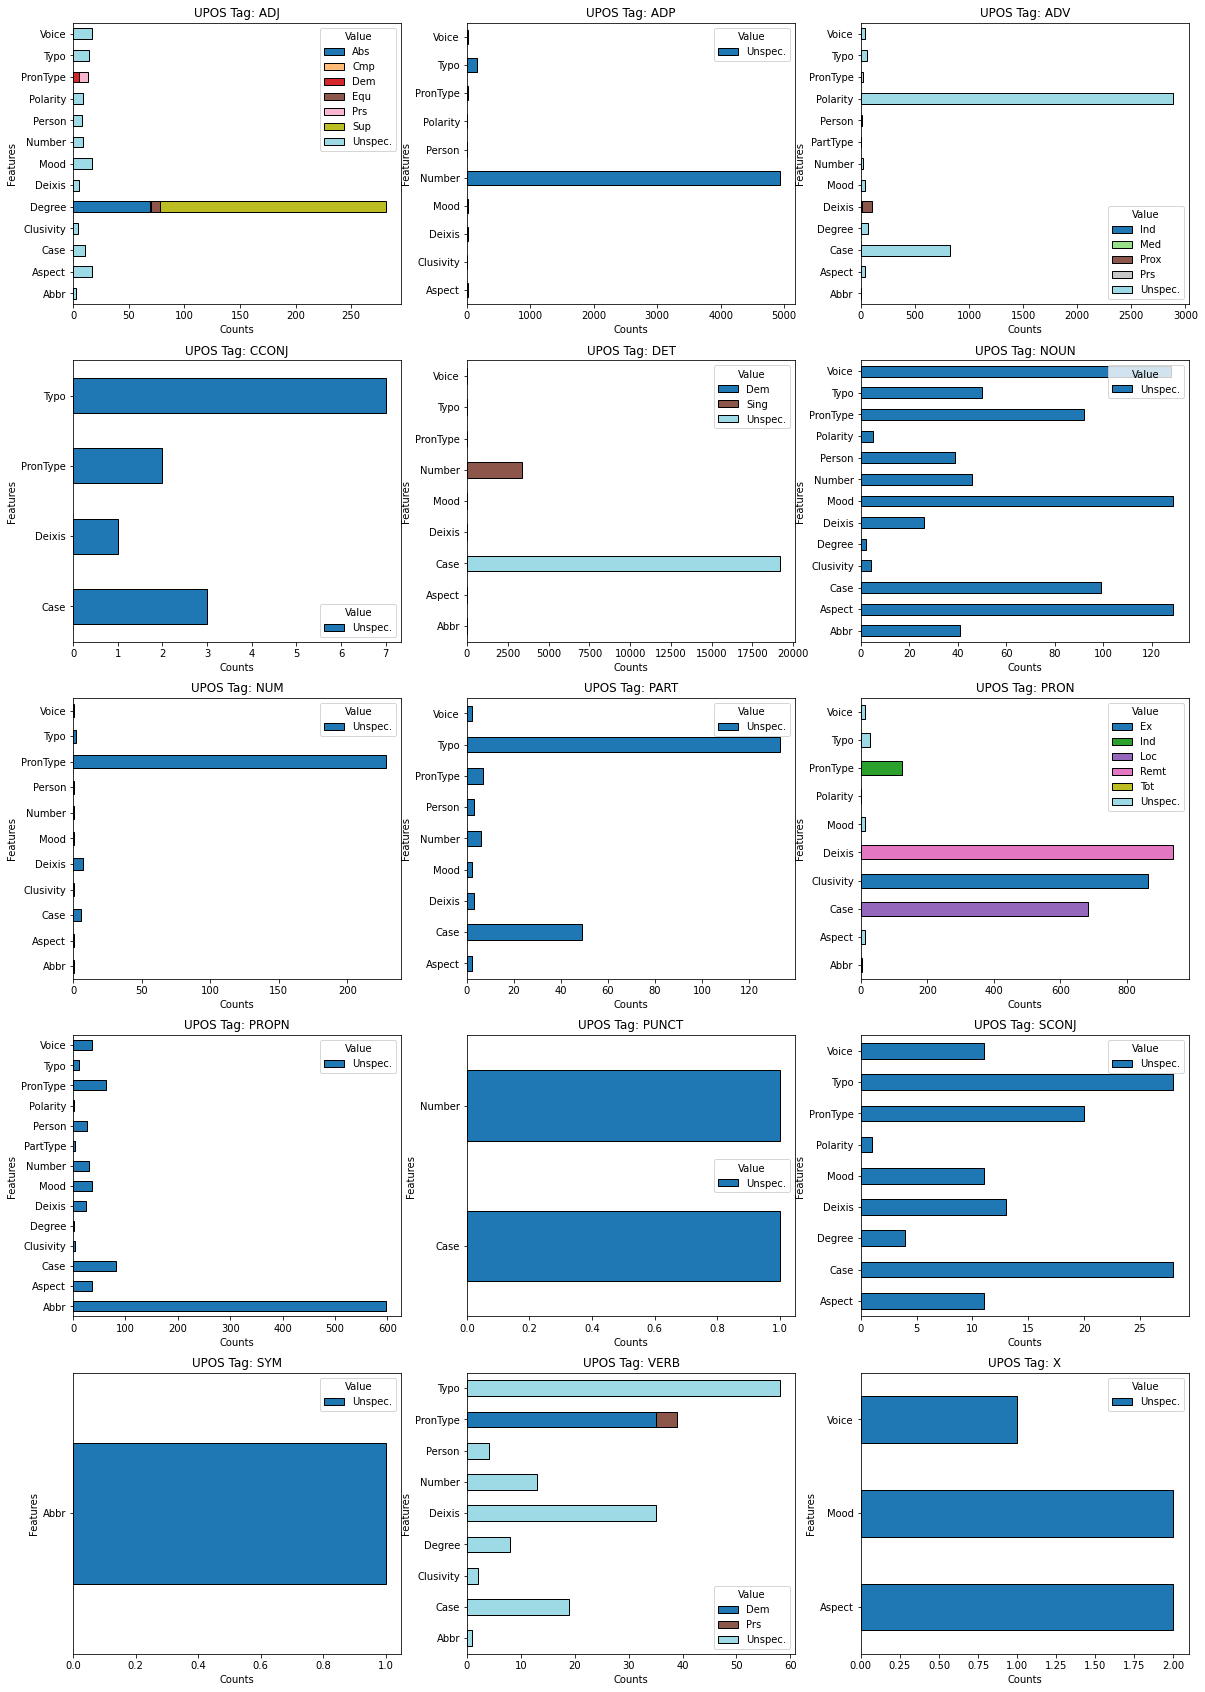

In [24]:
fig, axs = plt.subplots(5, 3, figsize=(20,30))
upos_tags = sorted(df_l4_upos["UPOS"].unique().to_list())
for ax, upos_tag in zip(axs.flat, upos_tags):
    plot_stacked_barchart(ax, upos_tag, df_l4_upos)
plt.savefig(f"figures/missing_feats_for_each_upos_tag.png", bbox_inches="tight", dpi=300) 